In [1]:

from keras.applications import inception_v3
from keras import backend as K

# disables all training operations
K.set_learning_phase(0)

# model loaded without convolutional base
# The model will be loaded with pretrainined Imagenet weights
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

Using TensorFlow backend.
W0411 08:18:11.596147 12256 deprecation_wrapper.py:119] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0411 08:18:12.016258 12256 deprecation_wrapper.py:119] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [2]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [3]:
# dictionary mapping layer names to a coefficeint indicating how much the layer activation will contribute toloss

layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 3.,
    'mixed4' : 2.,
    'mixed5' : 1.5,
}

In [4]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
    # changed loss += to loss = loss +

In [5]:
# now setting up gradient ascent process

#this will haveour generatedimage

dream = model.input
print(dream)

# compute the gradients of the dream with regard of the loss
grads= K.gradients(loss, dream)[0]
print(grads)

# noramlize the gradinets
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# set up functoin to retrieve the value
# of loss and gradients given to an input image

outputs = [loss,grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grad(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step,max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grad(x)
        if max_loss is not None and loss_value > max_loss:
            break
        
        print('..Loss value at ', i, ':', loss_value)
        x += step * grad_values
    
    return x



Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("gradients/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, ?, ?, 3), dtype=float32)


W0411 08:18:20.749736 12256 deprecation_wrapper.py:119] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [6]:
#!pip install imageio

In [7]:
from imageio import imsave

In [8]:
# Deep dream consists of series of scale
# where each scale upgrades by a factor of 1.4
# to avoid blur we will also reinject the image with details

import scipy

from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
              float(size[0])/img.shape[1],
              float(size[1])/img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imsave(fname, pil_img)

def preprocess_image(image_path):
    # convert image to tensors
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # to convert to image from tensors
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1,2,0))
    else :
        x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x = x / 2.
    x = x + 0.5
    x = x * 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [13]:
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10

base_image_path = './sunset.jpg'

img = preprocess_image(base_image_path)

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim/(octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)

shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Preprocessing image shape:', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step= step,
                          max_loss = max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img,shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original- upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Preprocessing image shape: (163, 261)
..Loss value at  0 : 1.0430311
..Loss value at  1 : 1.2700857
..Loss value at  2 : 1.7357345
..Loss value at  3 : 2.3138819
..Loss value at  4 : 2.8635461
..Loss value at  5 : 3.3845491
..Loss value at  6 : 3.9985788
..Loss value at  7 : 4.6776686
..Loss value at  8 : 5.202773
..Loss value at  9 : 5.780894
..Loss value at  10 : 6.341229
..Loss value at  11 : 6.8584647
..Loss value at  12 : 7.4198236
..Loss value at  13 : 7.8599076
..Loss value at  14 : 8.405847
..Loss value at  15 : 8.858822
..Loss value at  16 : 9.340549
..Loss value at  17 : 9.826226
Preprocessing image shape: (228, 365)
..Loss value at  0 : 2.6710997
..Loss value at  1 : 4.000539
..Loss value at  2 : 5.1779013
..Loss value at  3 : 6.200247
..Loss value at  4 : 7.089372
..Loss value at  5 : 7.9461627
..Loss value at  6 : 8.688605
..Loss value at  7 : 9.42938
Preprocessing image shape: (320, 512)
..Loss value at  0 : 2.9067452
..Loss value at  1 : 4.0402336
..Loss value at  2 : 5.

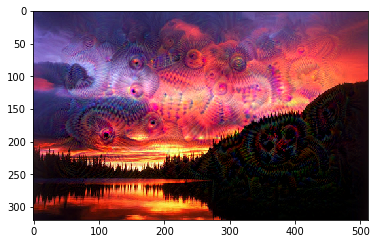

In [14]:
from matplotlib import pyplot as plt
plt.imshow(deprocess_image(np.copy(img)))
plt.show()